# Pratical session on convex optimization

## libraries
We start by importing **cvxpy** for solving convex optimisation programs, **sklearn** for generating the signals and **matplotlib** for plotting the results.

In [ ]:
from __future__ import division
import time
%pylab inline
%matplotlib inline
%load_ext autoreload
%autoreload 2

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import make_sparse_coded_signal
import numpy as np

import warnings
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


---

# Inverse Problem: Sparse recovery in high-dimension

----


We create an instance of a sparse linear inverse problem
$$ y = A z^\star $$
where $A$ has size dimension $m$ times $n$ with $m< n$. We consider a noisy version
$$ y_{\mathrm{noisy}}= A z^\star + e$$
where $e\sim\mathcal N(0, \sigma^2\mathrm{Id})$.

In [ ]:
# generate the data
# y = Az
# |z|_0 = n_nonzero_coefs
n = 2048
m = 512
k = 8
sigma = 0.05

A = np.random.randn(m,n)/np.sqrt(m)

z_star = np.random.binomial(1, p=k/n, size=(n,))*np.random.randn(n)

idx, = z_star.nonzero()

y = A.dot(z_star)

# distort the clean signal
y_noisy = y + sigma * np.random.randn(len(y))

print('We have an undersampling ratio m/n=', m/n*100, '% and there is', k/n*100,'% of nonzero entries')

We have an undersampling ratio m/n= 25.0 % and there is 0.390625 % of nonzero entries


We can plot the target signal $z^\star$ and the observed measurements $y$.

Text(0.5, 1.0, '$y_{noisy}$')

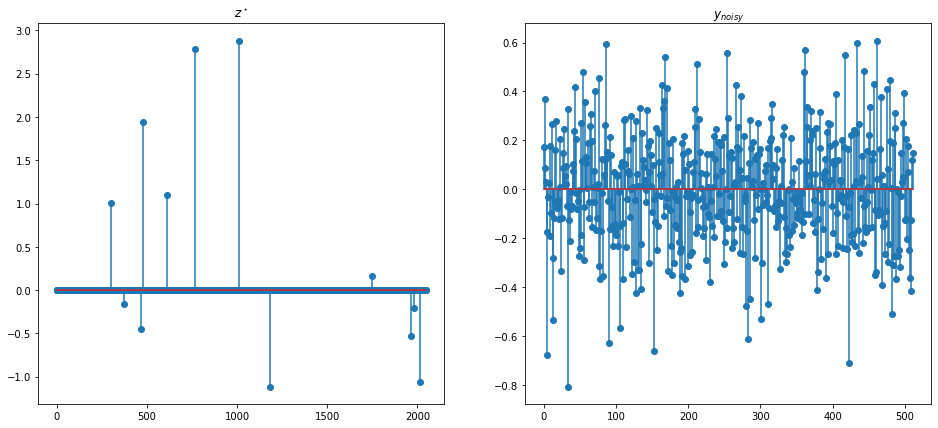

In [ ]:
fig, (subfig1,subfig2) = subplots(1,2,figsize=(16,7)) # one figure with two horizontal subfigures
subfig1.stem(z_star)
subfig2.stem(y_noisy)
subfig1.set_title('$z^\star$')
subfig2.set_title('$y_{noisy}$')

---

# LASSO

---
To recover an estimate of the signal $z^\star$, we consider  basis
pursuit denoising, which makes use of the $\ell^1$ norm as sparsity
enforcing penalty:
$$ \min_{x \in \mathbb R^d} \frac{1}{2} \|{A x-y}\|^2 + \lambda \|{x}\|_1, $$
The parameter $\lambda>0$ should be set in accordance to the noise level
$\|{w}\|$.


## Forward-Backward splitting

---

This minimization problem can be cast in the form of minimizing $f+g$
where
$$ f(x) = \frac{1}{2} \|{Ax-y}\|^2
\quad g(x) = \lambda \|{x}\|_1. $$

$f$ is smooth; we have
$$ \nabla f(x) = A^* (A x - y),  $$
which is $\beta$-Lipschitz continuous, with
$$ \beta = \|{ A^\top A }\|. $$

The Forward Backward iteration is

$$ x^{k+1}=  \text{prox}_{\gamma g}(x^{k}- \gamma \nabla f(x^{k}) )$$

with step size $\gamma< 2/\beta$. The proximal operator of the $\ell_1$ norm is simply soft
thresholding:
$$ \big(\text{prox}_{g}(x)\big)_n = \max\big\{ 0, 1 - \frac{\lambda}{|{x_n}|} \big\} x_n. $$

We define the proximity operator of $g$:

In [ ]:
def prox_g (x, Lambda) :
    return x - x/maximum(abs(x)/(Lambda), 1) # soft-thresholding

We define the gradient operator of $f$.

In [ ]:
grad_f = lambda x : A.transpose() @(A@x-y_noisy)

Hyper-parameters

In [ ]:
Lambda = .1 # regularization parameter try other values
gamma = .1 # step size try other values (or directly calculate the Lipschitz constant of A!)

The FB splitting method:

In [ ]:
nbiter = 1000
x = zeros(n)
En_array = zeros(nbiter+1)
En_array[0] = norm(A@(x) - y_noisy)**2/2 + Lambda*norm(x, ord=1)
start_time = time.time()
for iter in range(nbiter):  # iter goes from 0 to nbiter-1
    x = prox_g(x - gamma*grad_f(x), Lambda*gamma)
    En_array[iter+1] = norm(A@x - y_noisy)**2/2 + Lambda*norm(x, ord=1)
x_restored = x
print("--- %s seconds ---" % (time.time() - start_time))

--- 3.147704839706421 seconds ---


We plot the solutions

Text(0.5, 1.0, '$\\hat{z}$')

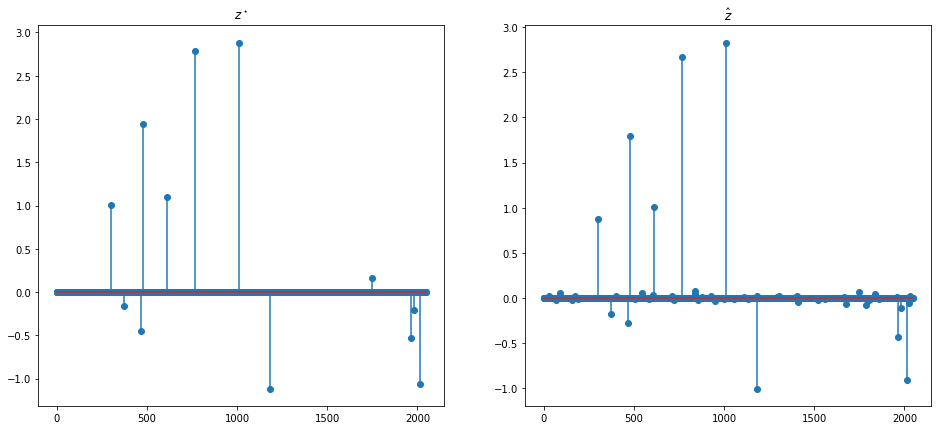

In [ ]:
fig, (subfig1,subfig2) = subplots(1,2,figsize=(16,7)) # one figure with two horizontal subfigures
subfig1.stem(z_star)
subfig2.stem(x_restored)
subfig1.set_title('$z^\star$')
subfig2.set_title('$\hat{z}$')

We plot the relative error $(E_k-E^\star)/(E_0-E^\star)$ in log-scale with respect to $k$.

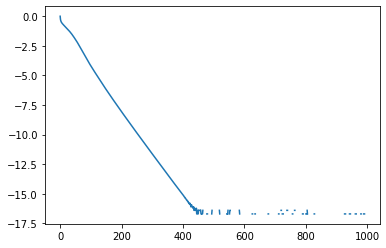

In [ ]:
plot(log10((En_array[0:nbiter]-En_array[-1])/(En_array[0]-En_array[-1])))

## FISTA-like Accelerated Forward-Backward Algorithm

------

We consider the FISTA algorithm introduced in:

> A. Beck and M. Teboulle,
"A Fast Iterative Shrinkage-Thresholding Algorithm for Linear Inverse Problems",
_SIAM Journal on Imaging Sciences_, 2009.

More precisely, we consider a slightly modified version of FISTA, whose convergence is proved, see
A. Chambolle and C. Dossal, "On the convergence of the iterates of "FISTA"", preprint, 2015.

Given an initial estimate $x^{(0)}$ of the solution and a parameter $a>2$, the algorithm sets $\gamma>0$, sets $z^{(0)}=x^{(0)} \in \mathbb R^d$,
and iterates, for $k=1,2,\ldots$
$$ x^{(k)} = \text{prox}_{\gamma g}\{
              z^{(k-1)} - \gamma \nabla f( z^{(k-1)} )  \}.
$$
$$ \alpha_k=(k-1)/(k+a) $$
$$ z^{(k)} = x^{(k)} +
      \alpha_k
  \{ x^{(k)} - x^{(k-1)} \} $$


It is proved that the iterates $x^{(k)}$ converge to a solution $x^\star$ of the problem. Moreover,
the  optimal convergence rate for this class of problems is reached,
namely
$$ E_k - E^\star = O(1/k^2), $$
whereas the convergence rate for the normal forward-backward is only
$O(1/k)$.

Note the difference between the over-relaxed forward-backward and the accelerated forward-backward: the later is based on an inertia mechanism, of different nature than over-relaxation.

In [ ]:
nbiter = 500
a = 10
x = zeros(n)
En_array_fista = zeros(nbiter+1)
En_array_fista[0] = norm(A@x - y_noisy)**2/2 + Lambda*norm(x, ord=1)
z = x
start_time = time.time()
for iter in range(nbiter):  # iter goes from 0 to nbiter-1
    xprevious = x
    x = prox_g(z - gamma*grad_f(z), Lambda*gamma)
    alpha = iter/(iter+1+a)
    z = x + alpha * (x - xprevious)
    En_array_fista[iter+1] = norm(A@x - y_noisy)**2/2 + Lambda*norm(x, ord=1)
x_restored = x
print("--- %s seconds ---" % (time.time() - start_time))

--- 1.0501337051391602 seconds ---


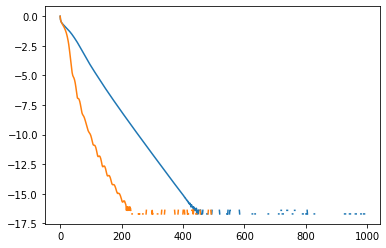

In [ ]:
plot(log10((En_array[0:1800]-En_array[-1])/(En_array[0]-En_array[-1])))
plot(log10((En_array_fista[0:1800]-En_array[-1])/(En_array[0]-En_array[-1])))

Text(0.5, 1.0, '$\\hat{z}$')

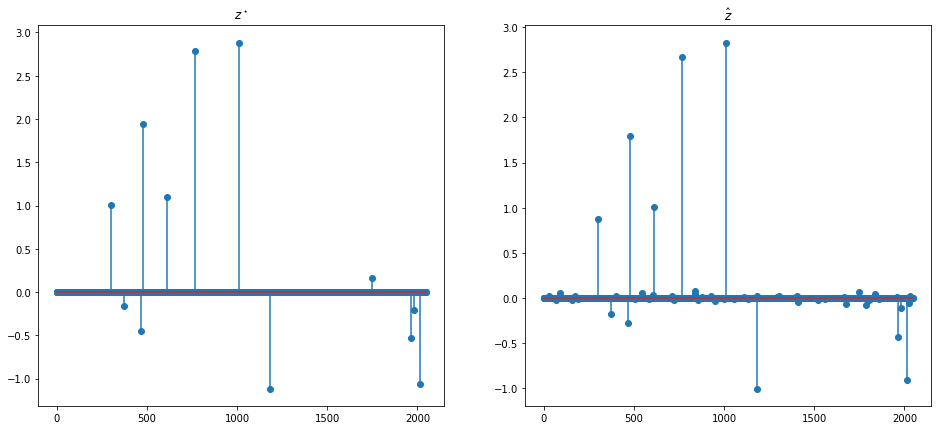

In [ ]:
fig, (subfig1,subfig2) = subplots(1,2,figsize=(16,7)) # one figure with two horizontal subfigures
subfig1.stem(z_star)
subfig2.stem(x_restored)
subfig1.set_title('$z^\star$')
subfig2.set_title('$\hat{z}$')

## The Douglas-Rachford algorithm

------------------------------------

The Douglas-Rachford (DR) algorithm is an iterative scheme to minimize
functionals of the form
$$\tag{DR} \min_{x} f(x) + g(x) $$
where $f$ and $g$ are convex functions, of which one is able to
compute the proximity operators. This algorithm was introduced in

> P. L. Lions and B. Mercier
"Splitting Algorithms for the Sum of Two Nonlinear Operators,"
_SIAM Journal on Numerical Analysis_
vol. 16, no. 6, 1979,


as a generalization of an algorithm introduced by Douglas and Rachford in
the case of quadratic minimization (which corresponds to solving
a positive definite linear system). To learn more about this algorithm, you can read:

> Patrick L. Combettes and Jean-Christophe Pesquet,
"Proximal Splitting Methods in Signal Processing,"
in: _Fixed-Point Algorithms for Inverse
Problems in Science and Engineering_, New York: Springer-Verlag, 2010.

An important observation (left as an exercice) is the following:

> If $x$ is a solution to (DR) then
$$x = \mathrm{prox}_{\gamma f} (s) $$
for some $s$ satisfying
$$ \mathrm{prox}_{\gamma f} (s) = \text{prox}_{\gamma g}( 2\mathrm{prox}_{\gamma f} (s)-s)$$
for any tunning paramter $\gamma >0$.

The Douglas-Rachford algorithm takes an arbitrary element $s^{(0)}$, a parameter $\gamma>0$, a relaxation parameter $0<\rho < 2$ and iterates, for $k=1,2,\ldots$

$$
\left|\begin{array}{l}
x^{(k)} = \mathrm{prox}_{\gamma f} (s^{(k-1)} )\\
s^{(k)} = s^{(k-1)}+\rho\big(\text{prox}_{\gamma g}( 2x^{(k)}-s^{(k-1)})-x^{(k)}\big).
\end{array}\right.
$$

It is of course possible to inter-change the roles of $f$ and $g$,
which defines a different algorithm. The iterates $x^{(k)}$ converge to a solution $x^\star$ of the problem, i.e. a minimizer of $f+g$. This algorithm is equivalent to the alternate direction method of multipliers (ADMM).

We set some hyper-parameters

In [ ]:
gamma = .5 # step size
rho = 1     # try 1, 1.5, 1.9

We set the number of iterations

In [ ]:
nbiter = 1000

We pick $f(x)=\frac{1}{2}\|Ax-y\|^2$, which has the proximity operator $\text{prox}_{\gamma f}(x)= x + A^{\dagger}(y-Ax)$ where $A^{\dagger}=(\gamma AA^{\top}+I)^{-1}(\gamma y+x)$ is the pseudo-inverse of $A$. Derive this yourself!

In [ ]:
B = inv(np.matmul(A.T,A)*gamma+np.eye(z_star.size))
def prox_gamma_f (x, y) :
    return B.dot(A.T.dot(y)*gamma+x)

Here the DR code:

In [ ]:
s = np.zeros(n)
En_array = np.zeros(nbiter)
start_time = time.time()
for iter in range(nbiter):  # iter goes from 0 to nbiter-1
    x = prox_gamma_f(s,y)
    s += rho*(prox_g(2*x-s, gamma*Lambda)-x)
    En_array[iter] = norm(x, ord=1)
x_restored = x
print("--- %s seconds ---" % (time.time() - start_time))

--- 3.8088672161102295 seconds ---


We plot the solutions

Text(0.5, 1.0, '$\\hat{z}$')

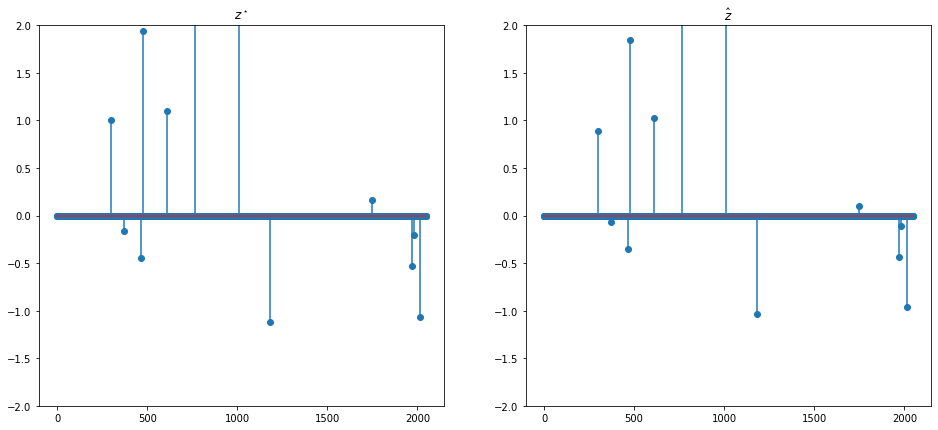

In [ ]:
fig, (subfig1,subfig2) = subplots(1,2,figsize=(16,7)) # one figure with two horizontal subfigures
subfig1.stem(z_star)
subfig1.set_ylim(-2,2)
subfig2.stem(x_restored)
subfig2.set_ylim(-2,2)
subfig1.set_title('$z^\star$')
subfig2.set_title('$\hat{z}$')

We plot the error wrt the number of iterations

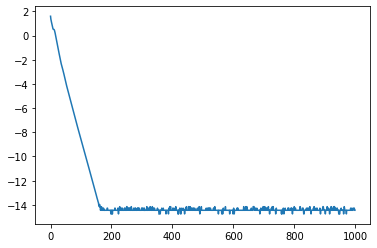

In [ ]:
plot(log10(En_array-En_array.min()))

## Lasso with CVXPY

A nice presentation on how to solve LASSO with CVXPY can be found at [CVXPY example on Lasso Regression ](https://www.cvxpy.org/examples/machine_learning/lasso_regression.html). We reproduce here the main features.

In [ ]:
import cvxpy as cp

def loss_fn(X, Y, beta):
    return cp.norm2(X @ beta - Y)**2

def regularizer(beta):
    return cp.norm1(beta)

def objective_fn(X, Y, beta, lambd):
    return (1/2)*loss_fn(X, Y, beta) + lambd * regularizer(beta)

def mse(X, Y, beta):
    return (1.0 / X.shape[0]) * loss_fn(X, Y, beta).value

In [ ]:
# The threshold value below which we consider an element to be zero.
delta = 1e-8

# Create variable.
z = cp.Variable(shape=n)

# Form objective.
obj = cp.Minimize(objective_fn(A, y_noisy, z, Lambda))

# Form and solve problem.
prob = cp.Problem(obj)

start_time = time.time()
prob.solve()
print("--- %s seconds ---" % (time.time() - start_time))
print("status: {}".format(prob.status))

# Number of nonzero elements in the solution (its cardinality or diversity).
nnz_l1 = (np.abs(z.value) > delta).sum()
print('Found a feasible x in R^{} that has {} nonzeros.'.format(n, nnz_l1))
print("optimal objective value: {}".format(obj.value))

idx_z = np.absolute(z.value) > delta
coeff = (np.absolute(z.value) > delta)*z.value
idx_z, = idx_z.nonzero()
ampl_z = z.value[idx_z]

print('Number of errors (MP):', np.mean(idx_z!=idx), 'Norm:', np.linalg.norm(z_star-coeff))

--- 25.57855224609375 seconds ---
status: optimal
Found a feasible x in R^2048 that has 72 nonzeros.
optimal objective value: 1.9039961861024581
Number of errors (MP): 1.0 Norm: 0.4490404126399353


Number of errors: 1.0 Norm: 0.4490404126399353


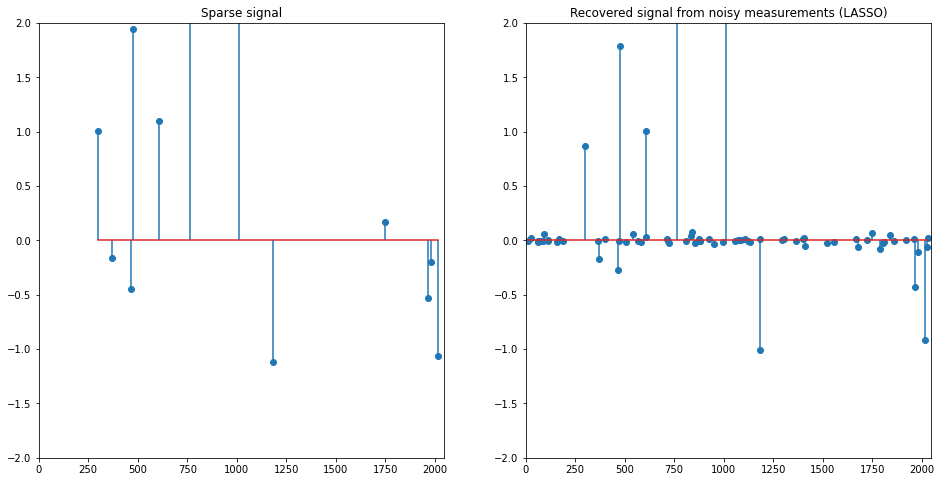

In [ ]:
# plot the sparse signal
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.ylim(-2,2)
plt.xlim(0, n)
plt.title("Sparse signal")
plt.stem(idx, z_star[idx], use_line_collection=True)

# reconstruction by LASSO

plt.subplot(1, 2, 2)
plt.ylim(-2,2)
plt.xlim(0, n)
plt.title("Recovered signal from noisy measurements (LASSO)")
plt.stem(idx_z, ampl_z, use_line_collection=True)

print('Number of errors:', np.mean(idx_z!=idx), 'Norm:', np.linalg.norm(z_star-z.value))

## Orthogonal Matching Pursuit (OMP)

---

We start by importing **scikit-learn** which has the following functions:

> omp = OrthogonalMatchingPursuit(n_nonzero_coefs=n_nonzero_coefs) where *n_nonzero_coefs* is the stopping criterion (number of atoms in the active support). In practice we choose this hyperparameter using cross validation (CV).

> omp.fit(A, y) that fits the OMP on the data.

In [ ]:
from sklearn.linear_model import OrthogonalMatchingPursuit
from sklearn.linear_model import OrthogonalMatchingPursuitCV

--- 0.04942178726196289 seconds ---
Number of errors (OMP): 1.0 Norme: 0.545223135508466


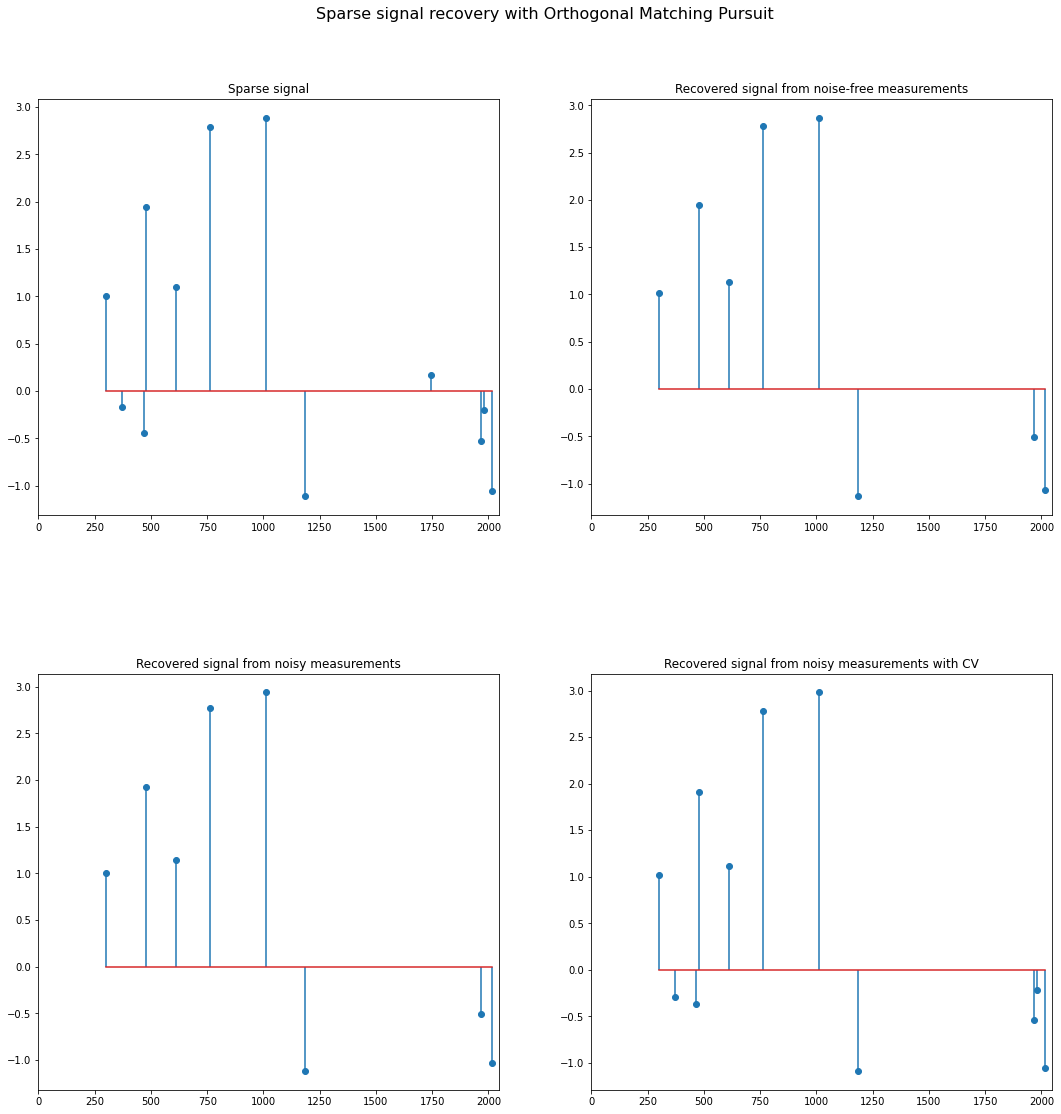

In [ ]:
# plot the sparse signal
plt.figure(figsize=(16, 16))
plt.subplot(2, 2, 1)
plt.xlim(0, n)
plt.title("Sparse signal")
plt.stem(idx, z_star[idx], use_line_collection=True)

# plot the noise-free reconstruction
omp = OrthogonalMatchingPursuit(n_nonzero_coefs=k)
start_time = time.time()
omp.fit(A, y)
print("--- %s seconds ---" % (time.time() - start_time))
coef = omp.coef_
idx_r, = coef.nonzero()
plt.subplot(2, 2, 2)
plt.xlim(0, n)
plt.title("Recovered signal from noise-free measurements")
plt.stem(idx_r, coef[idx_r], use_line_collection=True)

print('Number of errors (OMP):', np.mean(idx_r!=idx), 'Norme:', np.linalg.norm(z_star-coef))

# plot the noisy reconstruction
omp.fit(A, y_noisy)
coef = omp.coef_
idx_r, = coef.nonzero()
plt.subplot(2, 2, 3)
plt.xlim(0, n)
plt.title("Recovered signal from noisy measurements")
plt.stem(idx_r, coef[idx_r], use_line_collection=True)

# plot the noisy reconstruction with number of non-zeros set by CV
omp_cv = OrthogonalMatchingPursuitCV()
omp_cv.fit(A, y_noisy)
coef = omp_cv.coef_
idx_r, = coef.nonzero()
plt.subplot(2, 2, 4)
plt.xlim(0, n)
plt.title("Recovered signal from noisy measurements with CV")
plt.stem(idx_r, coef[idx_r], use_line_collection=True)

plt.subplots_adjust(0.06, 0.04, 0.94, 0.90, 0.20, 0.38)
plt.suptitle('Sparse signal recovery with Orthogonal Matching Pursuit',
             fontsize=16)
plt.show()